## Transformers

En este notebook, voy a explicar el modelo Transformers del artículo "Attention is All You Need" (2017) (https://arxiv.org/abs/1706.03762). Para ello, realizaré una implementación detallada usando la librería "PyTorch".

Cabe aclarar que la implementación de los módulos del Transformer en este notebook es solo con fines demostrativos. No están optimizadas y pueden contener errores. Es recomendable utilizar implementaciones optimizadas y bien testeadas, como las ya incluidas en PyTorch o, por ejemplo, la librería Transformers de Hugging Face.

El modelo consiste en dos partes principales: el codificador y el decodificador. Ambos están compuestos por una serie de capas de atención y capas feedforward, que a lo largo de este notebook se explicarán en detalle. También explicaré cómo se alimenta al modelo con texto mediante la "tokenización", cómo funcionan los embeddings de palabras y cómo se realiza el proceso de "positional encoding" descrito en el paper.

### Tokenizers


Como sabemos, una red neuronal no entiende de palabras sino de números, de modo que, para alimentarla con lenguaje natural, primero hay que dividir el texto en pequeñas partes y asignarles a cada parte un ID utilizando una técnica llamada tokenización.

Los tokenizers representan un campo amplio y complejo en sí mismos y son más una técnica de procesamiento que parte del modelo. Por el momento, me limitaré a dar una noción de su funcionamiento y centrarme en el aspecto práctico de estos. Cabe destacar que son una parte fundamental de cualquier modelo de lenguaje.

Básicamente, lo que hace un tokenizer es:
- Definir el vocabulario del modelo, es decir, el conjunto de palabras y tokens que puede procesar.
- Asignar un identificador único a cada palabra o token del vocabulario.
- Gestionar palabras o tokens que no están en el vocabulario del modelo (por ejemplo, palabras desconocidas o fuera del vocabulario).

Veamos un ejemplo utilizando el tokenizer "sentencepiece" de Google. Se pueden descargar pesos preentrenados desde la página: https://bpemb.h-its.org/.

In [1]:
from sentencepiece import SentencePieceProcessor

sentence = "Hola!, soy una frase a punto de ser tokenizada."


tokenizer = SentencePieceProcessor(model_file='tokenizers/es.wiki.bpe.vs1000.model')
pieces = tokenizer.EncodeAsPieces(sentence)
tokens = tokenizer.Encode(sentence)
print("Tokens: ", pieces)
print("IDs: ", tokens)
print(" ")

tokenizer = SentencePieceProcessor(model_file='tokenizers/es.wiki.bpe.vs5000.model')
pieces = tokenizer.EncodeAsPieces(sentence)

tokens = tokenizer.Encode(sentence)
print("Tokens: ", pieces)
print("IDs: ", tokens)
print(" ")

tokenizer = SentencePieceProcessor(model_file='tokenizers/es.wiki.bpe.vs200000.model')
pieces = tokenizer.EncodeAsPieces(sentence)
tokens = tokenizer.Encode(sentence)
print("Tokens: ", pieces)
print("IDs: ", tokens)

Tokens:  ['▁', 'H', 'ol', 'a', '!', ',', '▁so', 'y', '▁una', '▁f', 'ras', 'e', '▁a', '▁pun', 'to', '▁de', '▁ser', '▁to', 'k', 'en', 'iz', 'ada', '.']
IDs:  [905, 0, 64, 907, 963, 923, 195, 928, 95, 37, 176, 906, 8, 728, 56, 5, 201, 191, 942, 14, 136, 109, 924]
 
Tokens:  ['▁', 'H', 'ola', '!', ',', '▁so', 'y', '▁una', '▁f', 'ras', 'e', '▁a', '▁punto', '▁de', '▁ser', '▁to', 'k', 'en', 'izada', '.']
IDs:  [4905, 0, 1680, 4963, 4923, 195, 4928, 95, 37, 176, 4906, 8, 1687, 5, 201, 191, 4942, 14, 3383, 4924]
 
Tokens:  ['▁', 'H', 'ola', '!,', '▁soy', '▁una', '▁frase', '▁a', '▁punto', '▁de', '▁ser', '▁token', 'izada', '.']
IDs:  [199905, 0, 1680, 21037, 12510, 95, 8593, 8, 1687, 5, 201, 95436, 3383, 199924]


### Embeddings
Habiamos visto que una frase puede describirse como una secuencia de tokens, los cuales a su vez pueden ser representados con un tensor de números enteros del espacio $\mathbb{Z}^l$ con $l$ la longitud de la secuencia de tokens.

Los vectores de embeddings son la representación de dichos tokens en el espacio $\mathbb{R}^d$. Si bien existen implementaciones de embeddings pre-entrenados como por ejemplo Word2Vec, para entrenar LLMs se utilizan parámetros entrenables, de modo que el modelo mismo aprende la representación más adecuada para un modelo y los datos de entrenamiento específicos.

Sean $d \in \mathbb{N}$ la dimensión del espacio de embeddings, denominada a partir de ahora "dimensión del modelo" y $s \in \mathbb{N}$ el tamaño del vocabulario, es el número de distintos tokens producidos por el tokenizer. Podemos definir una matriz de pesos entrenable $W \in \mathbb{R}^{s \times d}$ la cual contenga a la representación en el espacio de embeddings del token con ID $i$ en la fila $i$

Podemos entonces obtener la secuencia de embeddings $X \in \mathbb{R}^{l \times d}$ correspondiente a una secuencia de tokens, simplemente tomando para cada token con ID $i$ en la secuencia, a la fila $i$ de la matriz de pesos. 

Veamos un ejemplo:

In [2]:
from torch import Tensor, IntTensor, int32
from torch.nn import Embedding
from torch.nn import Parameter

embedding = Embedding(3, 5)
embedding.weight = Parameter(data = Tensor([
    [0.1, 0.1, 0.1, 0.1, 0.1], 
    [0.2, 0.2, 0.2, 0.2, 0.2], 
    [0.3, 0.3, 0.3, 0.3, 0.3],
]))

sequence = IntTensor([[2, 0, 1]])
print(embedding(sequence))
print()

sequence = IntTensor([[2, 1]])
print(embedding(sequence))

tensor([[[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000]]],
       grad_fn=<EmbeddingBackward0>)

tensor([[[0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000]]],
       grad_fn=<EmbeddingBackward0>)


Vemos que el resultado de aplicar la capa de embedding a una secuencia es simplemente tomar las filas de la matriz correspondientes a los IDs de los tokens.

### Positional Encoding

A diferencia de las redes neuronales recurrentes (RNN) que se usaban para el procesamiento del lenguaje, el modelo Transformer no captura información sobre la posición de los embeddings de manera intrínseca, por lo que tenemos que proporcionarle esta información de alguna manera.

Para ello, el artículo propone una solución basada en números binarios llamada 'positional encoding'. Veamos de qué se trata; para ello, escribimos los primeros números decimales en representación binaria:

| Decimal | Binario |
|---------|---------|
| 0       | 0000    |
| 1       | 0001    |
| 2       | 0010    |
| 3       | 0011    |
| 4       | 0100    |
| 5       | 0101    |
| 6       | 0110    |
| 7       | 0111    |
| 8       | 1000    |

Si observamos con atención, que para los numeros binarios la primera columna desde la izquierda va como $0, 1, 0, 1, 0...$, la segunda columna va como $0, 0, 1, 1, 0, 0,...$, la tercera como $0, 0, 0 ,0, 1, 1, 1, 1...$ , si graficamos obtenemos ondas cuadradas.

/tmp/ipykernel_222240/2967852653.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


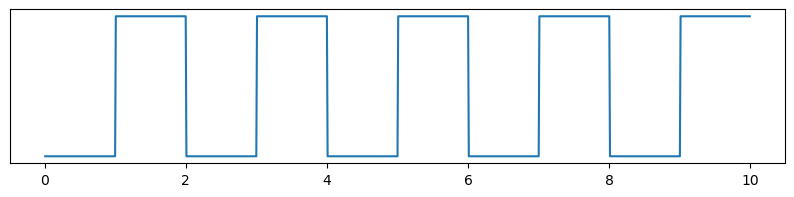

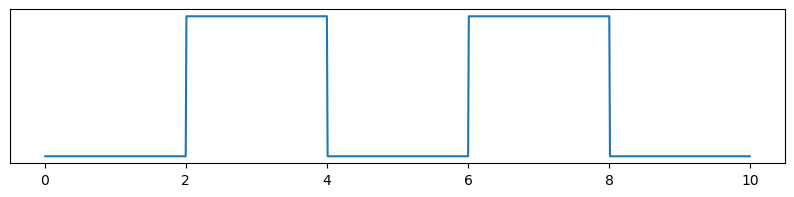

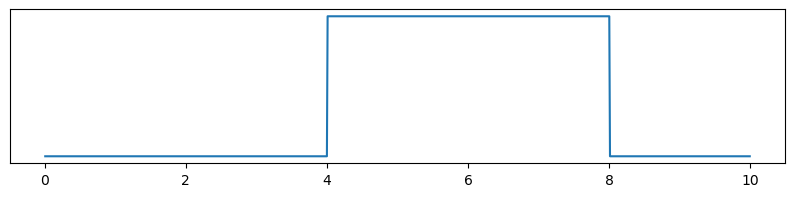

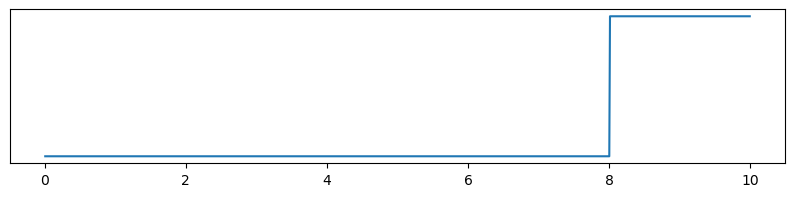

In [3]:
from numpy import arange, pi, sign, sin, where
from matplotlib.pyplot import figure, Axes

def square_sin(x, wave_lenght):
    return sign(-sin(x * pi / wave_lenght))

def plot_square_signal(ax: Axes, wave_lenght: float):
    x = arange(start=0.01, stop=10, step=0.01)
    y = square_sin(x, wave_lenght)
    ax.plot(x, y)
    ax.set_yticks([])

for step in [1,2,4,8]:
    plot = figure(figsize=(10, 2))
    ax = plot.add_subplot()
    plot_square_signal(ax, step)
    plot.show()

Esto nos da una noción de como podemos darle información sobre la posición de un token a la red, aproximando las ondas cuadradas mediante funciones $\sin$ y $\cos$, para aprovechar la representación en numeros flotantes, y sumandoselas a las secuencias de embeddings que ingresan al modelo.

Se puede profundizar mas en el porque de este metodo, como funcióna y aún mas interesante, por que funciona, siguiendo articulos como el siguiente: https://blog.timodenk.com/linear-relationships-in-the-transformers-positional-encoding/. Por el momento me voy a enfocar solo en la implementación.




Sean:

- $ X \in \mathbb{R}^{l \times d} $ una secuencia de $s$ vectores de vectores de embbeddings de dimension $d$.

$$ X = 

\begin{bmatrix}

    \vec{x}^1 \\
    \vec{x}^2 \\
    \vdots \\
    \vec{x}^l

\end{bmatrix}


= \begin{bmatrix}

    x^1_1 & x^1_2 & \cdots & x^1_d \\
    x^2_1 & x^2_2 & \cdots & x^2_d \\
    \vdots & \vdots & \ddots & \vdots \\
    x^l_1 & x^l_2 & \cdots & x^l_d

\end{bmatrix} $$

Con $ \vec{x}^t \in \mathbb{R}^d $ es el vector de embbedding de la palabra en la fila $t$ (posición del vector en la secuencia). Para informar a los vectores de embedding sobre su posición, se le suma a cada uno, el vector $ \vec{p} ^ t $ que describiremos a continuación.
 
$$ \vec{p}^t = \begin{bmatrix} p^t_1 & p^t_2 & \cdots p^t_d \end{bmatrix} $$ 

El paper propone una función de codificacion posicional $ \text{P}: \mathbb{N} \times \mathbb{N} \rightarrow \mathbb{R}^d $ como:

$$
\text{P}(t, s)  = 

\begin{cases} 
    \sin(\omega_k t) & \text{si } s = 2k \\
    \cos(\omega_k t) & \text{si } s = 2k + 1
\end{cases}
$$

Con las "frecuencias" definidas por $$ \omega_k = \frac{1}{N ^ {2 k /d}} = \exp(-\frac{2k}{d}\log(N))$$ 

Y $N$ es una constante.

La matrix de codificación posicional $ P \in \mathbb{R}^{l \times d} $ entonces sera:

$$ P = \begin{bmatrix}

    0 & 1 & 0 & 1 & \cdots & 0 & 1 \\
    \sin(\omega_1) & \cos(\omega_1) & \sin(\omega_2) & \cos(\omega_2) & \cdots & \sin(\omega_{d/2}) & \cos(\omega_{d/2}) \\
    \sin(\omega_1 2) & \cos(\omega_1 2) & \sin(\omega_2 2) & \cos(\omega_2 2) & \cdots & \sin(\omega_{d/2} 2) & \cos(\omega_{d/2} 2) \\
    \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
    \sin(\omega_1 (l-1)) & \cos(\omega_1 (l-1)) & \sin(\omega_2 (l-1)) & \cos(\omega_2 (l-1)) & \cdots & \sin(\omega_{d/2} (l-1)) & \cos(\omega_{d/2} (l-1))
\end{bmatrix} $$

En esta implementación, se considera que la matriz de codificación posicional $P$ se pre-computa una sola vez y se suma a la secuencia de embeddings $X$ en cada paso de la red.

$$ X := X + P $$


/tmp/ipykernel_222240/2397863013.py:43: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


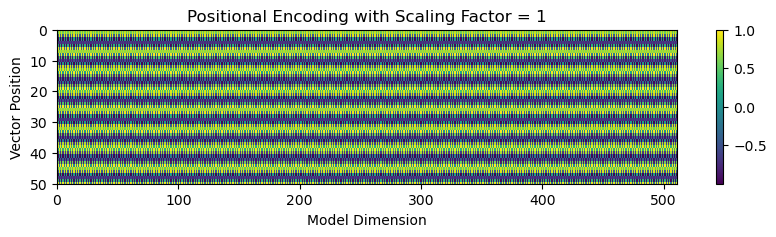

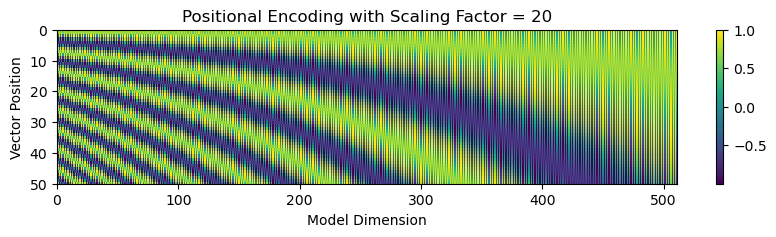

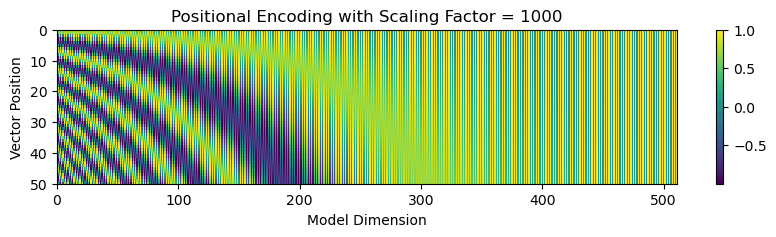

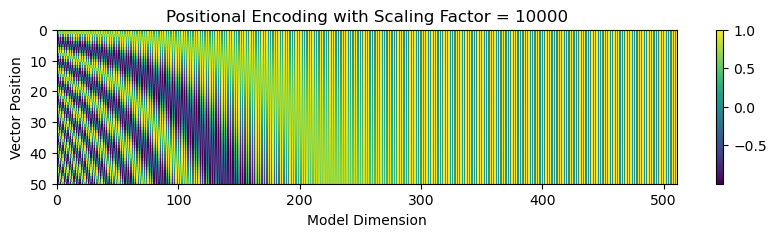

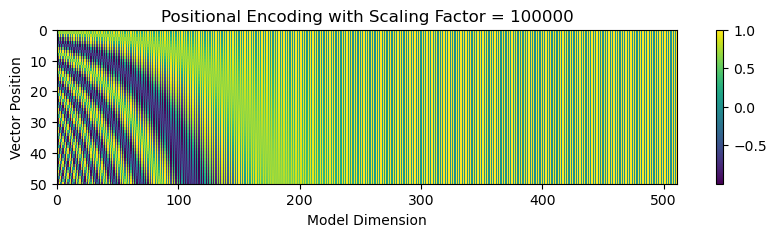

In [14]:
from numpy import exp, log, sin, cos
from numpy import arange, array

from matplotlib.pyplot import figure
from matplotlib.pyplot import Axes

def positional_encoding(sequence: int, model_dimension: int, scaling_factor: int = 10000):
    indexes = array([dimension // 2 + 1 for dimension in range(model_dimension)])
    frequencies = exp(-2*indexes * log(scaling_factor) / model_dimension)
    embeddings = array([
        sin(frequency * sequence) if index % 2 == 1 else 
        cos(frequency * sequence)
        for index, frequency in enumerate(frequencies, start=1)
    ])
    return embeddings


def plot_positonal_encoding(ax: Axes, scaling_factor: int = 10000):
    token_positions = arange(start=50, stop=-1, step=-1)
    encoding_dimension = 512

    x = arange(stop=encoding_dimension) 
    y = token_positions
    z = array([positional_encoding(token_position, encoding_dimension, scaling_factor) for token_position in token_positions])

    image = ax.pcolormesh(x, y, z, cmap='viridis')

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.max(), y.min())

    ax.set_xlabel('Model Dimension')
    ax.set_ylabel('Vector Position')
    ax.set_title(f'Positional Encoding with Scaling Factor = {scaling_factor}')

    return image


for scaling_factor in [1, 20, 1000, 10000, 100000]:
    plot = figure(figsize=(10, 2))
    ax = plot.add_subplot()
    image = plot_positonal_encoding(ax, scaling_factor)
    plot.colorbar(image, ax=ax, orientation='vertical')
    plot.show()

Como se pueden ver en los graficos, la codificación posicional es una onda cuadrada que se repite en cada dimensión, con una frecuencia que disminuye a medida que aumenta la dimensión. EL factor de escala $N$ es un hiperparametro que determina la escala de la onda cuadrada y casi no afecta el resultado para valores grandes. El paper propone $N = 10000$.

In [15]:
from torch import Tensor
from torch.nn import Module

class PositionalEncoding(Module):
    def __init__(self, sequence_lenght_limit: int, model_dimension: int):
        super().__init__()
        self.positional_embeddings = Tensor([positional_encoding(sequence, model_dimension,10000) for sequence in range(sequence_lenght_limit)])

    def forward(self, input: Tensor) -> Tensor:
        input = input + self.positional_embeddings[:,:input.size(1)]
        return input

### Self-Attention (Mecanismo de atención)

El concepto de key/value/query es análogo a los sistemas de busqueda. Por ejemplo, cuando busca videos en Youtube, el motor de búsqueda asigna su consulta (query) (texto en la barra de búsqueda) contra un conjunto de claves (keys) (título del video, descripción, etc.) asociadas con videos candidatos en su base de datos, y luego le presenta los con mayor coincidencia (values).

Para los modelos de lenguage, los key/value/query generalemente provienen de la misma fuente, es por esto que se denomina mecanismo de self-attention (atencion propia). La entrada consta de consultas y claves de dimensión $d_k$, y valores de dimensión $d_v$.

$$ \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Para entender un poco el por que funcióna esto, supongamos que los tensores $Q$ y $K$ son proyecciones de un tensor $X$, y pensemos el producto $QK^T$ como una especie de hamiltoniano de interacción entre los embeddings de consultas y claves (muy parecido al hamiltoniano de interacción entre spines). 

Tomemos $W^Q$ y $W^K$ tales que $Q = X W^Q$ y $K = X W^K$ con $X$ una secuencia de vectores de embedding, de modo que el producto anterior puede escribirse como:

$$ Q K^T = X (W^Q (W^K)^T) X^T$$

Podemos ver al termino $J_{ij} = -[W^Q (W^K)^T]_{ij} $ como una especie de termino de interacción entre dos embeddings, es decir, que tan fuerte interactuan dos tokens. Escribimos entonces al hamiltoniano de interacción entre tokens como:
 $$ \hat{H} = - \sum_{i,j} J_{ij} \vec{x^i} \cdot \vec{x^j}$$

Lo que obtuvimos es una maquina de Boltzmann, la cual se describe como una red neuronal recurrente estocástica. (https://es.wikipedia.org/wiki/M%C3%A1quina_de_Boltzmann), 

Pensemos ahora en términos de la mecánica estadística. La densidad de estados $\hat{\rho}$ del hamiltoniano $\hat{H}$, según el ensamble canónico puede escribirse como:

$$ \hat{\rho} = \frac{e^{-\beta \hat{H}}}{\text{Tra}(e^{-\beta \hat{H}})} $$

Con $\beta$ un parámetro que depende de una temperatura, el cúal omitiremos por ahora. Lo que obtuvimos fue una densidad de estados, la cúal podemos ver como un mapa que nos indica en dónde interactuan con mayor intensidad los embeddings del espacio de consultas (queries), y los del mapa de claves (keys), esto nos dará una especie de dirección de donde buscar en el en espacio de valores $V$ (values) o donde "prestar atención". Podemos entonces usar la densidad de estados $\hat{\rho}$, para encontrar los embeddings $X'$ con mayor relevancia:

$$ X' \approx \hat{\rho} V $$

Pero justamente la función de densidad de estados coincide con la definición de la función $\text{Softmax}$, agregando un término de normalización $d_k$, obtenemos entonces el resultado del mécanismo de atención.

$$ X' = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

Tomar esto con pinzas ya que es nada mas una interpretación mia del porqué el mecanismo de atención funciona como funciona. Sobre el tema hay un amplio campo de estudios denominado "Energy based models", en los cuales se modelan a las redes neuronales como sistemas físicos.

In [6]:
import math
from typing import Optional
from torch import Tensor
from torch.nn.functional import softmax

def attention(query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor] = None) -> Tensor:        
    variance = math.sqrt(key.size(-1))
    score = query @ key.transpose(-2, -1) / variance
    if mask is not None:
        score = score.masked_fill(mask == 0, float('-inf'))
    return softmax(score, dim=-1) @ value

Hay un termino adicional denominado mask, el cual se utiliza para evitar que el apagar conexiones entre tokens. En el caso de la atención propia, se utiliza una mascara triangular superior, de modo que los tokens futuros no puedan interactuar con los tokens pasados.

### Multihead attention

En el modelo transformers, el mecanismo de atención se aplica en paralelo a múltiples proyecciones de las consultas, claves y valores. Cada proyección se denomina "cabeza" de atención. Para definir estas proyecciones, se utilizan tres matrices de pesos $W^Q$, $W^K$ y $W^V$ que se aplican a las consultas, claves y valores respectivamente.

Sean:

- $W^Q \in \mathbb{R}^{d \times d_q}$
- $W^K \in \mathbb{R}^{d \times d_k}$
- $W^V \in \mathbb{R}^{d \times d_v}$

Con $d_q = d_k$. Dado un tensor $X \in \mathbb{R}^{l \times d}$, decimos que los productos:

- $X W^Q \in \mathbb{R}^{l \times d_k} $
- $X W^K  \in \mathbb{R}^{l \times d_k} $
- $X W^VX  \in \mathbb{R}^{l \times d_v}  $ 

Son las proyecciones del tensor $X$ en los espacios de consultas, claves y valores respectivamente. Podemos entonces definir el mecanismo de atención multi-cabezas como:

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \cdots, \text{head}_h) W^O $$
$$ \text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i) $$

Con $Q W^Q_i$, $K W^K_i$ y $V W^V_i$ son las proyecciones de los tensores $Q$, $K$ y $V$ en los espacios de consulta, clave y valor respectivamente, para una cabeza $\text{head}_i$, y $W^O$ es otra transformación que se aplica al resultado de concatenar las salidas de cada cabeza. Estas transformaciones son las encargadas de generar las distintas "cabezas" a partir de las consultas, claves y valores originales.

Aunque en la definicion de la capa del mecanismo de atencion multi-cabezas se generan distintas vistas para los tensores de entrada $Q$, $K$ y $V$, en la practica, es mas sencillo y eficiente computacionalmente, generar una sola proyección de estos tensores y luego dividirlos en $h$ partes, de modo que se generan las matrices $Q_i$, $K_i$ y $V_i$ para cada cabeza $i$. Esto puede lograrse de la siguiente manera:


Dada una proyección $ P \in \mathbb{R} ^ { l \times d } $, ya sea $P = W^Q Q, W^K K$ ó $W^V V$ podemos dividir cada fila de $P$ en $h$ partes de dimension $d/h$ y luego agrupar los vectores de cada parte en una matriz de dimension $l \times d/h$ en un mismo tensor agregando una dimension de la siguiente manera:

$$ P = \begin{bmatrix} 

    p^1_1 & p^1_2 & \cdots & p^1_d  \\
    p^2_1 & p^2_2 & \cdots & p^2_d   \\
    \vdots & \vdots & \ddots  & \vdots \\
    p^l_1 & p^l_2 & \cdots & p^l_d  \\

\end{bmatrix} \rightarrow \begin{bmatrix} 

    \begin{bmatrix} 

        p^1_1 & \cdots & p^1_{d/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        p^1_{d\frac{(h-1)}{h}+1} &  \cdots & p^1_d  \\

    \end{bmatrix} \\

    \vdots \\

    
    \begin{bmatrix} 

        p^l_1 & \cdots & p^l_{d/h}  \\

        
    \vdots & \ddots  & \vdots \\


        p^l_{d\frac{(h-1)}{h}+1} & \cdots & p^l_d  \\

    \end{bmatrix} \\

\end{bmatrix} \rightarrow \begin{bmatrix} 

    \begin{bmatrix} 

        p^1_1 & p^1_2 & \cdots & p^1_{d/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        p^l_1 & p^l_2 & \cdots & p^l_{d/h}  \\

    \end{bmatrix} \\

    \vdots \\

    
    \begin{bmatrix} 

        p^1_{d\frac{(h-1)}{h}+1}  & \cdots & p^1_d  \\

        
    \vdots & \vdots & \vdots \\


        p^l_{d\frac{(h-1)}{h}+1} & \cdots & p^l_d  \\

    \end{bmatrix} \\

\end{bmatrix} 

$$ 





De modo que definir $h$ proyectores $W^P$ de dimension $d/h \times d_p$ y multiplicarlos por los tensores de entrada, es igual a definir un solo tensor $W^P$ de dimension $d \times d_p$ con el cual se genera una sola proyeccion $P$, a partir del tensor de entrada, y luego realizar el "split" de la dimension $d$ en $h$ partes de dimension $d/h$.

De modo que el mecanismo de attención propia queda, para todas las cabezas como:

$$ \text{Attention}(Q, K, V) = \text{Softmax}(

\begin{bmatrix} 

    \begin{bmatrix} 

        q^1_1 & q^1_2 & \cdots & q^1_{d_k/h}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        q^l_1 & q^l_2 & \cdots & q^l_{d_k/h}  \\

    \end{bmatrix} 
    
    \begin{bmatrix} 

        k^1_1 & k^1_2 & \cdots & k^l_1  \\

        \vdots & \vdots & \ddots  & \vdots \\

        k^1_{d_k/h} & k^l_2 & \cdots & k^l_{d_k/h}  \\

    \end{bmatrix} \\ 
    
    \vdots \\ 
    
    \begin{bmatrix} 

        q^1_{d_k\frac{(h-1)}{h}+1} & \cdots & q^1_{d_k}  \\

        
    \vdots & \vdots & \ddots  & \vdots \\


        q^l_{d_k\frac{(h-1)}{h}+1} & \cdots & q^l_{d_k}  \\

    \end{bmatrix}

    \begin{bmatrix} 

        k^1_{d_k\frac{(h-1)}{h}+1} & \cdots &  k^l_{d_k\frac{(h-1)}{h}+1}  \\

        \vdots & \vdots & \vdots\\

        k^1_{d_k} & \cdots & k^l_{d_k}  \\

    \end{bmatrix} \\

\end{bmatrix} 

    / \sqrt{d_k/h} 
    
)

\begin{bmatrix} 

    \begin{bmatrix} 

        v^1_1 & v^1_2 & \cdots & v^1_{d_v/h}  \\
        \vdots & \vdots & \ddots  & \vdots \\
        v^l_1 & v^l_2 & \cdots & v^l_{d_v/h}  \\

    \end{bmatrix} \\

    \vdots \\

    \begin{bmatrix} 

        v^1_1 & v^1_2 & \cdots & v^1_{d_v/h}  \\
        \vdots & \vdots & \ddots  & \vdots \\
        v^l_1 & v^l_2 & \cdots & v^l_{d_v/h}  \\

    \end{bmatrix}

\end{bmatrix} $$ 

En donde cada matriz dentro de los tensores corresponde a una cabeza de atención. El resultado de la función de atención es un tensor de dimension $h \times l \times l$. El cual se multiplica por el tensor $V$ dando como resultado un tensor de dimension $h \times l \times d_v/h$.

La concatenación de las salidas de cada cabeza se realiza en la dimension $d_v/h$ y es el proceso inverso al descripto para el del "split" de modo que el resultado final es un tensor de dimension $l \times d_v$.

Finalmente, el output se multiplica por la matriz $W^O \in \mathbb{R}^{d_v \times d}$ para obtener el resultado final de la capa de atención multi-cabeza, el cual tendra dimension $l \times d$.


In [7]:
from typing import Optional
from torch import Tensor
from torch.nn import Module
from torch.nn import Linear

def split(sequence: Tensor, number_of_heads: int) -> Tensor:
    batch_size, sequence_length, model_dimension = sequence.size()
    sequence = sequence.view(batch_size, sequence_length, model_dimension // number_of_heads, number_of_heads)
    sequence = sequence.transpose(1, 2).contiguous()
    return sequence

def concat(sequence: Tensor) -> Tensor:
    batch_size, sequence_lenght, heads_dimension, number_of_heads = sequence.size()
    sequence = sequence.transpose(1, 2).contiguous()
    sequence = sequence.view(batch_size, sequence_lenght, heads_dimension* number_of_heads)
    return sequence

class MultiHead(Module):
    def __init__(self, model_dimension: int, key_dimension: int, value_dimension: int, number_of_heads):
        super().__init__()
        self.number_of_heads = number_of_heads
        self.query_projection = Linear(key_dimension, model_dimension, bias=False)
        self.key_projection = Linear(key_dimension, model_dimension, bias=False)
        self.value_projection = Linear(value_dimension, model_dimension, bias=False)
        self.output_projection = Linear(model_dimension, value_dimension)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, mask: Optional[Tensor]) -> Tensor:
        query, key, value = self.query_projection(query), self.key_projection(key), self.value_projection(value)
        query, key, value = split(query, self.number_of_heads), split(key, self.number_of_heads), split(value, self.number_of_heads)
        heads = attention(query, key, value, mask)
        heads = concat(heads)
        return self.output_projection(heads)

Luego se define la normalización por capa o "layer normalization", la cual se describe en el paper https://arxiv.org/pdf/1607.06450, el cual consiste en normalizar los valores de un tensor $X \in \mathbb{R}^{l \times d}$ a lo largo de la dimension $d$ para cada vector de la secuencia, de la siguiente manera:

$$ \text{LayerNorm}(X) = \gamma \frac{X - \mu}{\sqrt{\text{Var}(X) + \epsilon}} + \beta $$

En donde $\mu$ y $\text{Var}(X)$ son la media y la varianza de los valores de $X$ a lo largo de la dimension $d$ respectivamente, y $\gamma$ y $\beta$ son parametros que se aprenden durante el entrenamiento.

In [8]:
from torch import zeros, ones
from torch import sqrt
from torch import Tensor
from torch.nn import Parameter
from torch.nn import Module

class LayerNormalization(Module):
    def __init__(self, model_dimension: int, epsilon: float = 1e-12):
        super().__init__()
        self.gamma = Parameter(data=ones(model_dimension))
        self.beta = Parameter(data=zeros(model_dimension))
        self.epsilon = epsilon

    def forward(self, input: Tensor) -> Tensor:
        mean = input.mean(dim=-1, keepdim=True)
        variance = input.var(dim=-1, unbiased=True, keepdim=True)
        return self.gamma * ((input - mean) / sqrt(variance + self.epsilon)) + self.beta

### Capa feed forward (FFN)

La ultima (pero no menos importante) pieza importante en el transformer es la capa feedforward, la cual consiste simplemente en un autoencoder con una capa oculta y una función de activación. Esta se encarga, de tomar los concatenados de la atención multi-cabeza que describen las relaciones que nos interesan entre los tokens junto con la información original de los embeddings, y aprende a mezclarlos de modo que se obtiene una representación coherenete de la secuencia de tokens.

In [9]:
from torch import Tensor
from torch.nn import Module, Linear, ReLU, Sequential, Dropout

class FeedForward(Module):
    def __init__(self, model_dimension: int, hidden_dimension: int, dropout_rate: float = 0.2):
        super().__init__()
        self.layers = Sequential(
            Linear(model_dimension, hidden_dimension),
            ReLU(),
            Dropout(dropout_rate),
            Linear(hidden_dimension, model_dimension)
        )
    
    def forward(self, input: Tensor) -> Tensor:
        return self.layers(input)

### Arquitectura

Ya teniendo todas las piezas, podemos describir el modelo transformer completo.

El transformer descripto en el paper, consta de un bloque de codificación (Encoder) y un bloque de decodificación (Decoder), en donde el bloque de codificación consta de una capa de atención multi-cabeza, seguida de una capa feedforward y una capa de normalización por capa. El bloque de decodificación consta de dos capas de atención multi-cabeza, seguidas de una capa feedforward y una capa de normalización por capa.

Se puede diagramar de la siguiente manera:

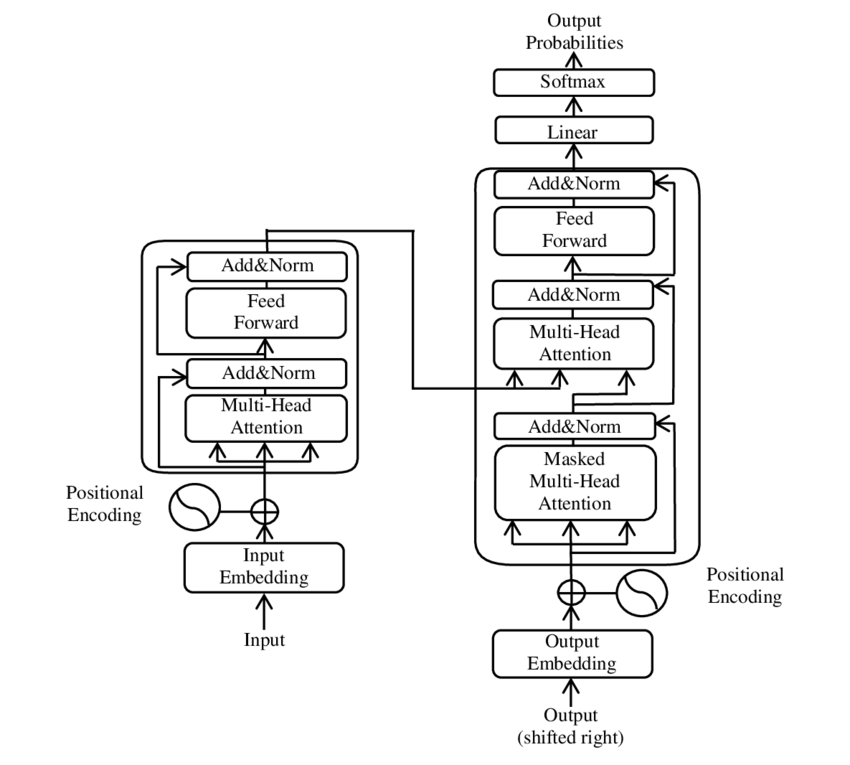

In [10]:
from torch import Tensor
from torch.nn import Module

class Encoder(Module):
    def __init__(self, model_dimension: int, ffn_dimension: int, number_of_heads: int, key_dimension: int, value_dimension: int):
        super().__init__()
        self.multihead_attention = MultiHead(model_dimension, key_dimension, value_dimension, number_of_heads)
        self.first_layer_normalization = LayerNormalization(model_dimension)

        self.feed_forward_network = FeedForward(model_dimension, ffn_dimension)
        self.second_layer_normalization = LayerNormalization(model_dimension)

    def forward(self, sequence: Tensor, mask: Tensor) -> Tensor:
        sequence = self.multihead_attention(sequence, sequence, sequence, mask) + sequence
        sequence = self.first_layer_normalization(sequence)
        
        sequence = self.feed_forward_network(sequence) + sequence
        sequence = self.second_layer_normalization(sequence)
        return sequence
    
    
class Decoder(Module):
    def __init__(self, model_dimension: int, ffn_dimension: int, number_of_heads: int, key_dimension: int, value_dimension: int):
        super().__init__()
        self.first_multihead_attention = MultiHead(model_dimension, key_dimension, value_dimension, number_of_heads)
        self.first_layer_normalization = LayerNormalization(model_dimension)

        self.second_multihead_attention = MultiHead(model_dimension, key_dimension, value_dimension, number_of_heads)
        self.second_layer_normalization = LayerNormalization(model_dimension)
        
        self.feed_forward_network = FeedForward(model_dimension, ffn_dimension)
        self.third_layer_normalization = LayerNormalization(model_dimension)

    def forward(self, input: Tensor, output: Tensor, input_mask: Tensor, output_mask) -> Tensor:
        output = self.first_multihead_attention(output, output, output, output_mask) + output
        output = self.first_layer_normalization(output)

        output = self.second_multihead_attention(input, input, output, input_mask) + output
        output = self.second_layer_normalization(output)

        output = self.feed_forward_network(output) + output
        output = self.third_layer_normalization(output)
        return output

In [11]:
from dataclasses import dataclass

from torch import Tensor
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import Softmax

@dataclass
class Configuration:
    vocabulary_size: int
    model_dimension: int
    feed_forward_hidden_dimension: int
    number_of_heads: int
    key_dimension: int
    value_dimension: int
    encoder_layers: int
    decoder_layers: int

class Transformer(Module):
    def __init__(self, configuration: Configuration):
        super().__init__()
        self.embedding = Embedding(configuration.vocabulary_size, configuration.model_dimension)
        self.positional_encoding = PositionalEncoding(512, configuration.model_dimension)
        self.encoder = ModuleList([Encoder(
            configuration.model_dimension, 
            configuration.feed_forward_hidden_dimension, 
            configuration.number_of_heads, 
            configuration.key_dimension, 
            configuration.value_dimension
        ) for layer in range(configuration.encoder_layers)])

        self.decoder = ModuleList([Decoder(
            configuration.model_dimension, 
            configuration.feed_forward_hidden_dimension, 
            configuration.number_of_heads, 
            configuration.key_dimension, 
            configuration.value_dimension
        ) for layer in range(configuration.decoder_layers)])

        self.linear = Linear(configuration.model_dimension, configuration.vocabulary_size)
        self.softmax = Softmax(dim=-1)

        self.input_mask = None
        self.output_mask = None

    def forward(self, input: Tensor, output: Tensor) -> Tensor:
        input, output = self.embedding(input), self.embedding(output)
        input, output = self.positional_encoding(input), self.positional_encoding(output)

        for layer in self.encoder:
            input = layer(output, self.input_mask)

        for layer in self.decoder:
            output = layer(input, output, self.input_mask, self.output_mask)

        output = self.linear(output)
        output = self.softmax(output)
        return output

Y eso es todo, una simple implementación del paper "Attention is all you need" (2017). Recordar que esta implementación es solo con fines demostrativos ya que hay versiones optimizadas y bien testeadas en la misma libreria. Ademas omiti detalles como agregar dropout en algunas capas, o la implementación de las "masks", proximamente voy a agregar estos detalles.

Para entrenar un modelo se deberian utilizar los modulos ya implementados en PyTorch que pueden ser importados simplemente como:

In [13]:
from torch.nn import Transformer
from torch.nn import TransformerEncoder, TransformerDecoder
from torch.nn import TransformerDecoderLayer, TransformerEncoderLayer
from torch.nn import MultiheadAttention
from torch.nn.functional import scaled_dot_product_attention